# Tree decomposition, treewidth, and other stories

In [ ]:
import networkx as nx

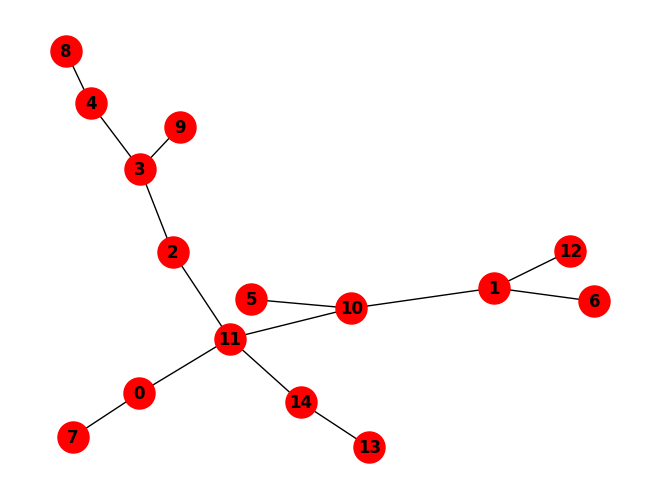

In [ ]:
Tree = nx.generators.random_labeled_tree(15, seed = 42)
nx.draw(Tree, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')

# Maximum Independent Set on Trees
Maximum independent set is a classical NP-Complete problem.
NP-Complete problems are usually difficult to solve and require extensive computation. On trees, many NP-Complete problems can be solved efficiently and in an exact way in linear time, using dynamic programming.

> **Definition (Independent set)**: Let $G = (V, E)$, an independent set $IS(G)$ is a set of nodes $C \subset V$ such that no edges exist between these nodes.
>
> Formally: $$ IS(G) = \left\{ C \subset V:\quad \forall u, v \in C\; \nexists (u,v) \in E\right\}$$

Let's implement a function to compute the maximum independent set on a tree using dynamic programming. We define two tables $M^+[v]$, where we store the size of the largest independent set in $v$'s subtree, including the node $v$ and $M^-[v]$, where we store the size of the largest independent set in $v$'s subtree excluding the node v. With this wto tables we can solve the MIS on a tree in linear time as follows. we root the tree on a random node and we visit the nodes of the tree in postorder (dfs). For each node with children $w_1, \dots ,w_d$ we compute the following:

$$
 M^+[v] = 1 + \sum_{i=0}^{i=d} M^-[w_i]\\
 M^-[v] = \sum_{i=0}^{i=d} \max{\left(M^+[w_i], M^-[w_i]\right)}
$$

NetworkX offers two useful functions here:
- bfs\_successors: which takes a tree and a root node and returns the successors of each node
- dfs\_postorder\_nodes: which, given a tree and a root node, returns the the nodes of the tree in postorder

We compute the MIS on the tree we plotted above.

In [ ]:
from random import randint

def MIS_on_tree(tree):
    size = len(tree)
    root = randint(0,size-1)
    m_plus = [0 for i in range (size)]
    m_minus = m_plus.copy()
    successors_dict = dict(nx.bfs_successors(tree, root))
    leaves = [node for node in tree if node not in successors_dict.keys()]

    for node in list(nx.dfs_postorder_nodes(tree, root)):
      if node in leaves:
        m_plus[node] = 1
        m_minus[node] = 0
      else:
        node_successors = successors_dict[node]
        childrens_m_minuses = [m_minus[i] for i in range(size) if i in node_successors]
        childrens_m_pluses = [m_plus[i] for i in range(size) if i in node_successors]
        m_plus[node] = 1 + sum(childrens_m_minuses)
        maximums = []

        for i in range (len(childrens_m_pluses)):
          maximums.append(max([childrens_m_pluses[i], childrens_m_minuses[i]]))

        m_minus[node] = sum(maximums)

    return max([m_plus[root], m_minus[root]])


In [ ]:
MIS_on_tree(Tree)

8

# Tree Decomposition of Graphs

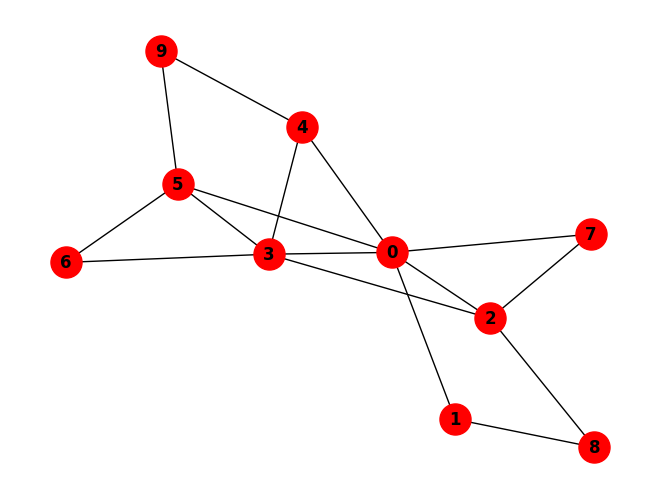

In [ ]:
G = nx.Graph(
    [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (1, 8), (2, 3),
     (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (4, 9), (5, 6), (5, 9)]
)
pos = pos = nx.spring_layout(G)
nx.draw(G, pos=pos, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')

Let's compute the tree decomposition with the minimum degree heuristic

In [ ]:
w, T = nx.approximation.treewidth_min_degree(G) # Yes! NetworkX offers an implementation of the algorithm you have seen today!
print("The graph G has treewidth at most %d; as such, %d cops are sufficient to catch a robber in this graph." %(w, w+1))

The graph G has treewidth at most 3; as such, 4 cops are sufficient to catch a robber in this graph.


Let's plot the tree decomposition

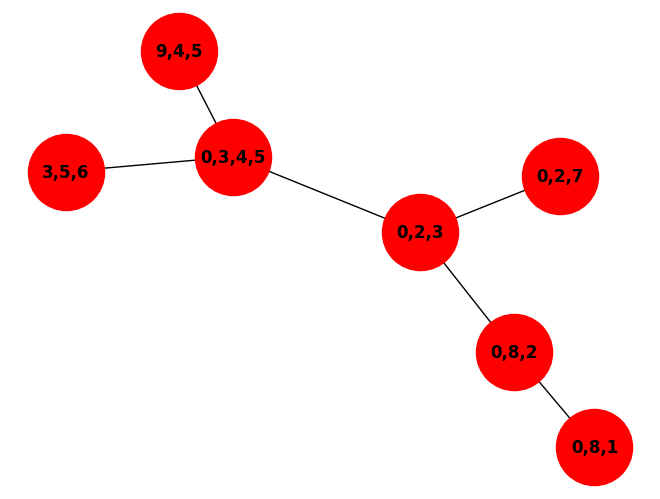

In [ ]:
labels = {node:','.join(list(map(str, node))) for node in T}
nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)

Let's implement a function to perform a tree decomposition of a graph. We assume first that the elimination order is given. Later on we will focus on the minimum degree heuristic.
Given an elimination order, we need to remove each node from a graph, make a bag with the node we have just removed and its neighbours, and triangulate the neighbours in the graph (that is, we connect all the neighbours of the node we have removed with each other).
If the bag is already a subset of an existing bag, we discard it.
When we have removed all the nodes, we connect each bag with the bag for which the intersection of the nodes contained in the bags is the maximum.

In [ ]:
def bag_is_subset(candidate_bag, bags):
  set_candidate = set(candidate_bag)
  for bag in bags:
    if set_candidate <= set(bag):
      return True
  return False

def get_neighbors_list(graph, node):
    return [neighbor for neighbor in graph.neighbors(node) if neighbor != node]

def get_intersection_elems_dict(bag, bags):
    remaining_bags = tuple([b for b in bags if b != bag])
    num_common_elems = {b: 0 for b in remaining_bags}
    for other_bag in remaining_bags:
      common = 0
      for elem in bag:
        if elem in other_bag:
          common += 1
      num_common_elems[other_bag] = common
    return num_common_elems, max(num_common_elems.values())


def remove_and_triangulate_neighbors(graph, to_be_eliminated, neighbors):
    # remove the node
    graph.remove_node(to_be_eliminated)

    # triangulate its neighbors
    for i in range(len(neighbors)-1):
      for j in range(i+1, len(neighbors)):
        graph.add_edge(neighbors[i],neighbors[j])

def tree_decomposition(G, elimination_order):
    graph = G.copy()
    tree = nx.Graph()
    bags = []
    while len(elimination_order) > 0:
      to_be_eliminated = elimination_order.pop(0)

      # get neighbors
      neighbors = get_neighbors_list(graph, to_be_eliminated)

      # create candidate bag
      candidate_bag = [to_be_eliminated]
      candidate_bag.extend(neighbors)

      remove_and_triangulate_neighbors(graph, to_be_eliminated, neighbors)

      # add the candidate bag iff no superset of it are already in the bags list
      # we convert to tuple so that it can be hashed by the dict
      if not bag_is_subset(candidate_bag, bags):
        candidate_bag.sort()
        bags.append(tuple(candidate_bag))

    # add the bags in the tree
    for bag in bags:
      tree.add_node(bag)

    # sort the bags
    bags.sort()

    # connect them
    for bag in bags:
      intersection_dict, max_intersection = get_intersection_elems_dict(bag, bags.copy())
      for key, val in intersection_dict.items():
        if val == max_intersection and not nx.has_path(tree, bag, key):
          tree.add_edge(bag, key)

    # get the tree_width
    width = max([len(bag) for bag in bags]) - 1

    return width, tree

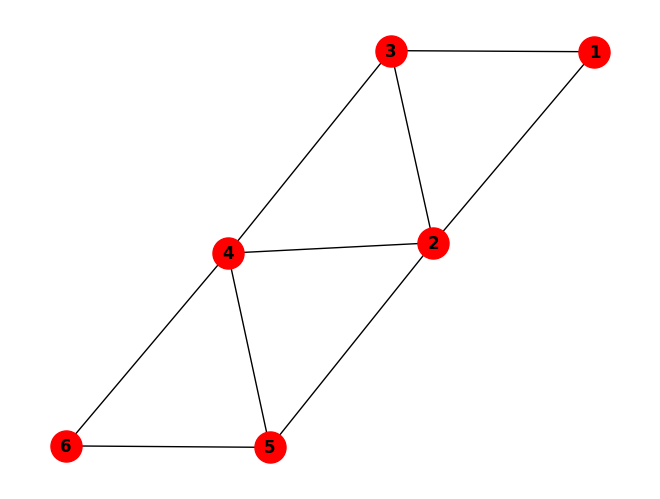

In [ ]:
G2 = nx.Graph(
    [(1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (2, 5), (4, 5), (5, 6), (4, 6)]
)
pos = pos = nx.spring_layout(G2)
nx.draw(G2, pos=pos, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')

Consider this graph and obtain a tree decomposition

In [ ]:
# It should print "The graph G has treewidth at most 3; as such, 4 cops are sufficient to catch a robber in this graph."
w, T = tree_decomposition(G2, [1,2,3,4,5,6])
print("The graph G has treewidth at most %d; as such, %d cops are sufficient to catch a robber in this graph." %(w, w+1))

The graph G has treewidth at most 3; as such, 4 cops are sufficient to catch a robber in this graph.


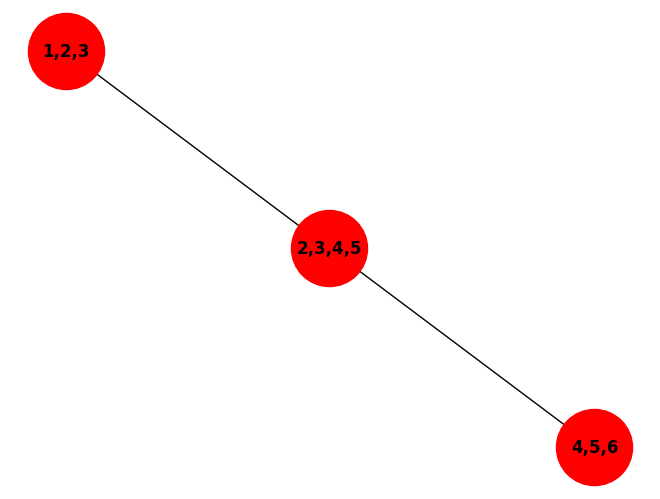

In [ ]:
# It should plot a line tree with three bags, two of which contain 3 nodes and one contains 4 nodes.
labels = {node:','.join(list(map(str, node))) for node in T}
nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)

Let's consider a different node removal order

In [ ]:
# It should print "The graph G has treewidth at most 2; as such, 3 cops are sufficient to catch a robber in this graph."
w, T = tree_decomposition(G2, [1,3,2,4,5,6])
print("The graph G has treewidth at most %d; as such, %d cops are sufficient to catch a robber in this graph." %(w, w+1))

The graph G has treewidth at most 2; as such, 3 cops are sufficient to catch a robber in this graph.


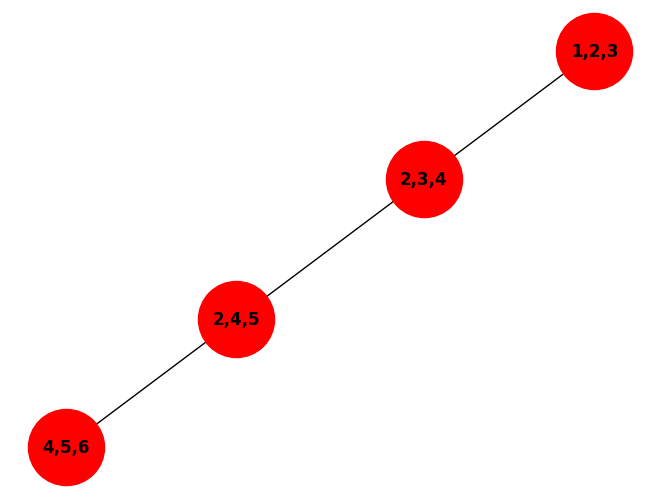

In [ ]:
# It should plot a line tree with four bags, each containing 3 nodes
labels = {node:','.join(list(map(str, node))) for node in T}
nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)

This shows that the elimination order matters. So, now, let's implement the minimum degree heuristic to obtain a good elimination order.

In [ ]:
def min_degree_elimination_order(G):
    elimination_order = list()
    graph = G.copy()
    current_nodes = graph.nodes()

    while len(current_nodes) > 0:
      node_degrees = {}
      for node in current_nodes:
        neighbors = get_neighbors_list(graph, node)   # definition above
        node_degrees[node] = len(neighbors)
      min_degree_node = min(node_degrees, key=node_degrees.get)
      remove_and_triangulate_neighbors(graph, min_degree_node, get_neighbors_list(graph, min_degree_node))    # definition above
      elimination_order.append(min_degree_node)

    return elimination_order

min_degree_elimination_order(G)

[1, 7, 8, 2, 6, 9, 0, 3, 4, 5]

Let's consider again the first graph G. Let's now compute the tree decomposition with the minimum degree heuristic.

In [ ]:
w, T = tree_decomposition(G,
 min_degree_elimination_order(G))
print("The graph G has treewidth at most %d; as such, %d cops are sufficient to catch a robber in this graph." %(w, w+1))

The graph G has treewidth at most 3; as such, 4 cops are sufficient to catch a robber in this graph.


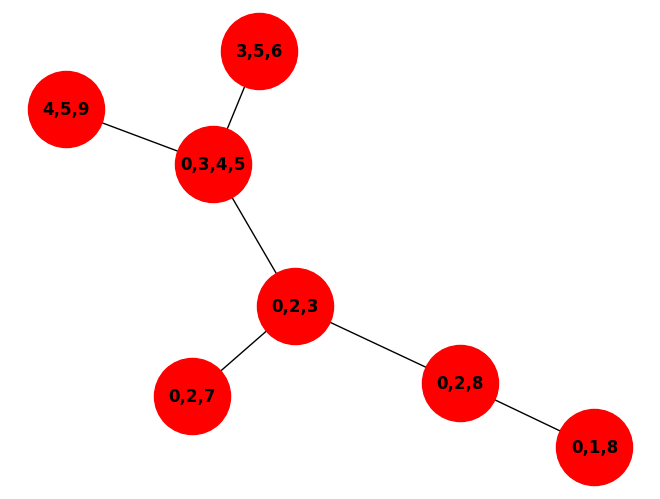

In [ ]:
# This should plot a tree decomposition equivalent to the one obtained by the NetworkX function
labels = {node:','.join(list(map(str, node))) for node in T}
nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)

# Dynamic programming on tree decompositions

We can apply dynamic programming on a graph of bounded treewidth (that is, a graph for which the treewidth is small) using the tree decomposition of said graph. Similarly to what we have done on trees, we need to build dynamic programming tables. However, instead of having dynamic programming tables based on the nodes of the tree, this time we have dynamic programming tables based on the bags of the tree decomposition. So, each bag will be associated to a table which is exponential in the number of the nodes contained in said bag. If the bag is $X = \left\{1, 2, 3 \right\}$ we need to create a table with the following entries: $\left\{\emptyset \right\}$, $\left\{1 \right\}$, $\left\{2 \right\}$, $\left\{3 \right\}$, $\left\{1, 2 \right\}$, $\left\{1, 3 \right\}$, $\left\{2, 3 \right\}$, $\left\{1, 2, 3 \right\}$.

Using the usual bottom-up dynamic programming approach, we build the tables and perform the required computations until we reach the root of the tree decomposition. This time, differently from the way we do it on a tree, we will need to explicitly take care of devising a solution for the nodes at the intersection between two adjacent bags. In fact, if we consider the nodes in a bag as a small almost independent sub-problem, the nodes at the intersection between a parent bag and a child bag represent the nodes which do not make the bags fully independent. So we will need to devise a solution that account for those nodes at the intersection. The final solution to our problem will be, again, contained in the tables associated with the root bag.

Let's continue with the maximum independent set. This time we are going to implement a function to compute the maximum independent set on a generic graph, using a tree decomposition. For a bag $X_i$ of the tree decomposition, let $D_i$ be the union of the bags $X_{j}$ descending from $X_i$. For each independent set $S \subset X_i$ the table $A[S,i]$ will contain the size of the largest independent set $I \subset D_i$ such that $I \cap X_i = S$. Similarly, for each couple of adjacent (i.e. connected with a link) bags $X_i, X_k$ such that $X_i$ is the successor of $X_k$ and for an independent set $S \subset X_i \cap X_k$, the table $B[S,i,j]$ will contain the size of the largest independent set $I \subset D_i$ such that $I \cap X_i \cap X_k = S$.

In sum, for each node $X_i$ of the tree decomposition, we compute the following dynamic programming tables:
$$
A\left[ S,i \right] = \left| S \right| + \sum_j B \left[ S \cap X_j,j \right] - \left| S \cap X_j \right| \\
B\left[ S,i \right] = \max_{S' \subset X_i \atop S = S' \cap X_k} A[S', i]
$$

As we did for the MIS on trees, we will root the tree decomposition on a random bag and we will compute the aforementioned values by visiting the bags of the tree decomposition in postorder. This time we will need to know also the predecessors of the bags.

The function to compute the MIS on a graph $G$ takes in input the graph $G$ itself and its tree decomposition $T$. We will need to check if a subset of nodes is an independent set, so we will also write a function that checks whether a set is independent or not. To check if a set of nodes $S$ is independent we just have to check that there is no edge between any two nodes in $S$. The Maximum Independent Set of the graph $G$, given a tree decomposition $T$, once we computed the tables is defined as follows:
$$
MIS(G) = \max_{S \subset R} B[S, R]
$$

In [ ]:
from itertools import combinations, permutations

# This function returns a generator to the powerset of S
def powerset(S):
    N = len(S) + 1
    for i in range(N):
        for subset in combinations(S, i):
            yield frozenset(subset)


# A function to check that a given set S is an independent set in the graph G
def is_independent_set(S, G):
    assert all([node in G.nodes() for node in S]), "The nodes in S must be in G"
    for u, v in permutations(S, 2):
        if (u,v) in G.edges():
            return False
    return True


###################### MY FUNCS ######################

def get_A_max(A, bag, s_prime):
    max = 0
    for key, val in A.items():
      # key is the tuple (subset, bag)
      a_s = key[0]
      a_bag = key[1]
      if a_bag == bag and a_s == s_prime and val > max:
        max = val
    return max


def get_parent_bag(bag, successors):
    for key, val in successors.items():
      if bag in val:
        return key
    return(frozenset())


def MIS_with_tree_decomposition(G, T):
    tree_nodes = [node for node in T.nodes()]
    random_root = tree_nodes[randint(0, len(tree_nodes)-1)]

    # initialize tables
    A = {}
    B = {}

    # get successors and leaves
    successors_dict = dict(nx.bfs_successors(T, random_root))
    leaves = [node for node in T if node not in successors_dict.keys()]
    b_max = 0

    for bag in nx.dfs_postorder_nodes(T, random_root):
      subsets = powerset(bag)
      parent_bag = get_parent_bag(bag, successors_dict)
      is_root = (bag == random_root)

      # get all the subsets in a bag which are independent sets in the original graph
      independent_subsets = [subset for subset in subsets if is_independent_set(subset,G)]

      # calculate A
      for s in independent_subsets:
        A[(s,bag)] = len(s)
        if bag not in leaves:
          second_part_of_A_expression = 0
          for succ in successors_dict[bag]:
            intersection = s.intersection(succ)
            second_part_of_A_expression += B[intersection, succ] - len(intersection)
          A[(s,bag)] += second_part_of_A_expression

      # calculate B
      for s_prime in independent_subsets:
        if is_root:
          u = s_prime
        else:
          u = s_prime.intersection(parent_bag)
        B[(u,bag)] = get_A_max(A, bag, s_prime)

        if B[(u,bag)] > b_max:
          b_max = B[(u,bag)]

    return b_max

In [ ]:
G = nx.Graph(
    [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (1, 8), (2, 3),
     (2, 7), (2, 8), (3, 4), (3, 5), (3, 6), (4, 9), (5, 6), (5, 9)]
)
w, T = nx.approximation.treewidth_min_degree(G)

# It should print 4
MIS_with_tree_decomposition(G, T)

4